# Ноутбук 4: Перенос и простая адаптация доменов на EMNIST (искусственный сдвиг)

**Цель:** Показать перенос и настройку под "другой" домен при той же целевой задаче.

**Что делаем:**
1. Конструирование доменов через кластеризацию PCA пространства
2. Upper bounds - обучение отдельно на S и T
3. Transfer learning - обучение на S, оценка на T
4. Feature extraction - заморозка энкодера
5. Partial fine-tuning - разморозка верхних слоев
6. Domain adaptation с CORAL/MMD штрафом
7. Псевдоразметка на неразмеченных данных
8. Сравнение всех методов


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


Using device: cuda
GPU: NVIDIA L40
GPU memory: 44.38 GB


## 1. Загрузка данных из baseline

Загружаем предобработанные данные из первого ноутбука.


In [2]:
# Загрузка данных из baseline
checkpoint_dir = Path("./checkpoints/baseline")
data_dir = checkpoint_dir / "data"

X_train = np.load(data_dir / "X_train_scaled.npy")
X_val = np.load(data_dir / "X_val_scaled.npy")
X_test = np.load(data_dir / "X_test_scaled.npy")
y_train = np.load(data_dir / "y_train.npy")
y_val = np.load(data_dir / "y_val.npy")
y_test = np.load(data_dir / "y_test.npy")

print(f"Данные загружены:")
print(f"  Train: {len(X_train):,}")
print(f"  Val: {len(X_val):,}")
print(f"  Test: {len(X_test):,}")
print(f"  Input dim: {X_train.shape[1]}")
print(f"  Classes: {len(np.unique(y_train))}")


Данные загружены:
  Train: 628,138
  Val: 69,794
  Test: 116,323
  Input dim: 784
  Classes: 62


## 2. Конструирование доменов

Создаем искусственные домены S (source) и T (target) путем кластеризации train данных в PCA пространстве. Это создает "сдвиг домена" при сохранении пересечения классов между доменами.


In [3]:
def create_domains(X, y, n_clusters=2, n_components=50, random_state=42):
    """
    Создает домены через кластеризацию в PCA пространстве.
    Возвращает индексы для source и target доменов, а также обученные pca и kmeans.
    """
    print(f"Применение PCA с {n_components} компонентами...")
    pca = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca.fit_transform(X)
    
    print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.4f}")
    
    print(f"Кластеризация на {n_clusters} кластера...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca)
    
    # Разделяем на домены
    domain_indices = {}
    for i in range(n_clusters):
        domain_indices[i] = np.where(cluster_labels == i)[0]
        print(f"  Домен {i}: {len(domain_indices[i]):,} примеров")
    
    return domain_indices, X_pca, cluster_labels, pca, kmeans

def ensure_class_overlap(domain_indices, y, min_classes_per_domain=30):
    """
    Проверяет и обеспечивает пересечение классов между доменами.
    """
    all_classes = set(np.unique(y))
    
    for domain_id, indices in domain_indices.items():
        domain_classes = set(np.unique(y[indices]))
        print(f"  Домен {domain_id}: {len(domain_classes)} уникальных классов")
        
        if len(domain_classes) < min_classes_per_domain:
            print(f"    Предупреждение: домен {domain_id} имеет мало классов")
    
    # Проверка пересечения
    if len(domain_indices) >= 2:
        domain_classes_list = [set(np.unique(y[indices])) for indices in domain_indices.values()]
        intersection = set.intersection(*domain_classes_list)
        print(f"\nПересечение классов между доменами: {len(intersection)} классов")
        
        if len(intersection) < min_classes_per_domain:
            print(f"  Предупреждение: мало пересекающихся классов")
    
    return True

# Создание доменов
domain_indices, X_pca, cluster_labels, pca_fitted, kmeans_fitted = create_domains(X_train, y_train, n_clusters=2, n_components=50)
ensure_class_overlap(domain_indices, y_train, min_classes_per_domain=30)

# Разделение на source (S) и target (T)
source_idx = domain_indices[0]
target_idx = domain_indices[1]
target_cluster_id = 1  # Изначально target соответствует кластеру 1

# Если первый домен меньше, меняем местами
if len(source_idx) < len(target_idx):
    source_idx, target_idx = target_idx, source_idx
    target_cluster_id = 0  # После обмена target соответствует кластеру 0

print(f"\nИтоговое разделение:")
print(f"  Source (S): {len(source_idx):,} примеров")
print(f"  Target (T): {len(target_idx):,} примеров")
print(f"  Target cluster ID: {target_cluster_id}")

X_source = X_train[source_idx]
y_source = y_train[source_idx]
X_target = X_train[target_idx]
y_target = y_train[target_idx]


Применение PCA с 50 компонентами...
Объясненная дисперсия: 0.6601
Кластеризация на 2 кластера...
  Домен 0: 239,088 примеров
  Домен 1: 389,050 примеров
  Домен 0: 62 уникальных классов
  Домен 1: 62 уникальных классов

Пересечение классов между доменами: 62 классов

Итоговое разделение:
  Source (S): 389,050 примеров
  Target (T): 239,088 примеров
  Target cluster ID: 0



Разделение target домена:
  Target labeled: 7,172 примеров (3.0%)
  Target unlabeled: 231,916 примеров (97.0%)
  Target val: 26,471 примеров
  Target test: 44,261 примеров


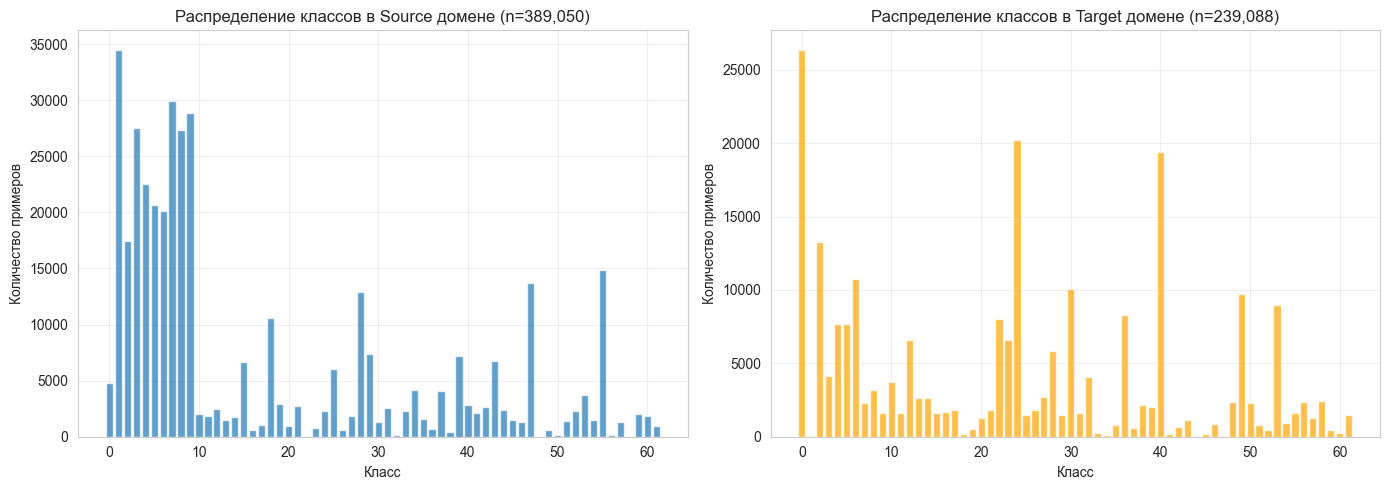

In [4]:
# Разделение T на labeled (1-5%) и unlabeled части
target_labeled_ratio = 0.03  # 3% размеченных данных

# Разделяем с сохранением распределения классов
X_target_labeled, X_target_unlabeled, y_target_labeled, y_target_unlabeled = train_test_split(
    X_target, y_target,
    test_size=1 - target_labeled_ratio,
    stratify=y_target,
    random_state=42
)

# Также создаем val/test для target домена из оригинальных val/test
# Используем обученные PCA и kmeans из Cell 5
X_val_pca = pca_fitted.transform(X_val)
X_test_pca = pca_fitted.transform(X_test)

# Используем обученный kmeans для предсказания домена
val_clusters = kmeans_fitted.predict(X_val_pca)
test_clusters = kmeans_fitted.predict(X_test_pca)

# Берем примеры, принадлежащие target домену (используем правильный cluster ID)
target_val_idx = np.where(val_clusters == target_cluster_id)[0]
target_test_idx = np.where(test_clusters == target_cluster_id)[0]

X_target_val = X_val[target_val_idx]
y_target_val = y_val[target_val_idx]
X_target_test = X_test[target_test_idx]
y_target_test = y_test[target_test_idx]

print(f"\nРазделение target домена:")
print(f"  Target labeled: {len(X_target_labeled):,} примеров ({target_labeled_ratio*100:.1f}%)")
print(f"  Target unlabeled: {len(X_target_unlabeled):,} примеров ({(1-target_labeled_ratio)*100:.1f}%)")
print(f"  Target val: {len(X_target_val):,} примеров")
print(f"  Target test: {len(X_target_test):,} примеров")

# Визуализация распределения классов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Source домен
source_classes, source_counts = np.unique(y_source, return_counts=True)
axes[0].bar(source_classes, source_counts, alpha=0.7)
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Количество примеров')
axes[0].set_title(f'Распределение классов в Source домене (n={len(y_source):,})')
axes[0].grid(True, alpha=0.3)

# Target домен
target_classes, target_counts = np.unique(y_target, return_counts=True)
axes[1].bar(target_classes, target_counts, alpha=0.7, color='orange')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Количество примеров')
axes[1].set_title(f'Распределение классов в Target домене (n={len(y_target):,})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Архитектура модели

Определяем архитектуру энкодера и классификационной головы для экспериментов с domain adaptation.


In [5]:
class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], dropout=0.3, embedding_dim=128):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, embedding_dim))
        self.encoder = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.encoder(x)
    
    def get_features(self, x, layer_idx=-1):
        """Получить признаки из промежуточного слоя"""
        features = x
        for i, layer in enumerate(self.encoder):
            features = layer(features)
            if i == layer_idx:
                break
        return features

class ClassifierHead(nn.Module):
    def __init__(self, embedding_dim, n_classes):
        super().__init__()
        self.classifier = nn.Linear(embedding_dim, n_classes)
    
    def forward(self, embeddings):
        return self.classifier(embeddings)

class DomainAdaptationModel(nn.Module):
    def __init__(self, input_dim, n_classes, hidden_dims=[512, 256, 128], 
                 dropout=0.3, embedding_dim=128):
        super().__init__()
        self.encoder = MLPEncoder(input_dim, hidden_dims, dropout, embedding_dim)
        self.classifier = ClassifierHead(embedding_dim, n_classes)
    
    def forward(self, x):
        embeddings = self.encoder(x)
        logits = self.classifier(embeddings)
        return logits, embeddings
    
    def get_embeddings(self, x):
        with torch.no_grad():
            return self.encoder(x)

input_dim = X_train.shape[1]
n_classes = len(np.unique(y_train))
embedding_dim = 128

print(f"Архитектура модели:")
print(f"  Input dim: {input_dim}")
print(f"  Embedding dim: {embedding_dim}")
print(f"  Classes: {n_classes}")


Архитектура модели:
  Input dim: 784
  Embedding dim: 128
  Classes: 62


In [6]:
def coral_loss(source_features, target_features):
    """
    CORAL loss: выравнивание ковариационных матриц между доменами.
    """
    # Нормализация признаков
    source_features = F.normalize(source_features, p=2, dim=1)
    target_features = F.normalize(target_features, p=2, dim=1)
    
    # Вычисление ковариационных матриц
    source_cov = compute_covariance(source_features)
    target_cov = compute_covariance(target_features)
    
    # Разница между ковариационными матрицами
    loss = torch.mean(torch.pow(source_cov - target_cov, 2))
    return loss

def compute_covariance(features):
    """Вычисляет ковариационную матрицу признаков"""
    n = features.size(0)
    # Центрирование
    features = features - torch.mean(features, dim=0, keepdim=True)
    # Ковариационная матрица
    cov = torch.mm(features.t(), features) / (n - 1)
    return cov

def mmd_loss(source_features, target_features, kernel='rbf', sigma=1.0):
    """
    MMD (Maximum Mean Discrepancy) loss между распределениями доменов.
    """
    if kernel == 'rbf':
        # RBF kernel
        def rbf_kernel(X, Y):
            XX = torch.sum(X ** 2, dim=1, keepdim=True)
            YY = torch.sum(Y ** 2, dim=1, keepdim=True)
            XY = torch.mm(X, Y.t())
            return torch.exp(-sigma * (XX + YY.t() - 2 * XY))
        
        # Вычисление MMD
        K_ss = rbf_kernel(source_features, source_features)
        K_tt = rbf_kernel(target_features, target_features)
        K_st = rbf_kernel(source_features, target_features)
        
        # MMD^2 = E[k(xs, xs')] + E[k(xt, xt')] - 2*E[k(xs, xt)]
        mmd = torch.mean(K_ss) + torch.mean(K_tt) - 2 * torch.mean(K_st)
        return mmd
    else:
        # Linear kernel (проще и быстрее)
        source_mean = torch.mean(source_features, dim=0)
        target_mean = torch.mean(target_features, dim=0)
        mmd = torch.norm(source_mean - target_mean, p=2) ** 2
        return mmd

print("Функции потерь для domain adaptation определены:")
print("  - CORAL: выравнивание ковариационных матриц")
print("  - MMD: максимальное среднее расхождение")


Функции потерь для domain adaptation определены:
  - CORAL: выравнивание ковариационных матриц
  - MMD: максимальное среднее расхождение


## 5. Вспомогательные функции для обучения и оценки

Создаем функции для обучения моделей и оценки результатов.


In [7]:
def train_epoch(model, dataloader, optimizer, criterion, device, 
                freeze_encoder=False, domain_loss_fn=None, lambda_domain=0.0,
                source_dataloader=None):
    """Одна эпоха обучения"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    if freeze_encoder:
        for param in model.encoder.parameters():
            param.requires_grad = False
    
    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(dataloader, leave=False)):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
        logits, embeddings = model(X_batch)
        loss = criterion(logits, y_batch)
        
        # Добавляем domain loss если нужно
        if domain_loss_fn is not None and source_dataloader is not None:
            # Берем батч из source домена
            try:
                X_source_batch, _ = next(iter(source_dataloader))
                X_source_batch = X_source_batch.to(device)
                _, source_embeddings = model(X_source_batch)
                domain_loss = domain_loss_fn(source_embeddings, embeddings)
                loss = loss + lambda_domain * domain_loss
            except:
                pass
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    """Оценка модели"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            logits, _ = model(X_batch)
            _, predicted = torch.max(logits.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    return accuracy, f1_macro, all_preds, all_labels

def train_model(model, train_loader, val_loader, n_epochs=20, lr=0.001,
                freeze_encoder=False, domain_loss_fn=None, lambda_domain=0.0,
                source_dataloader=None, early_stopping_patience=5):
    """Полное обучение модели"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_val_f1 = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
    
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, device,
            freeze_encoder=freeze_encoder,
            domain_loss_fn=domain_loss_fn,
            lambda_domain=lambda_domain,
            source_dataloader=source_dataloader
        )
        
        val_acc, val_f1, _, _ = evaluate(model, val_loader, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1={val_f1:.4f}")
        
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return history

print("Вспомогательные функции определены")


Вспомогательные функции определены


In [8]:
# Создание DataLoader'ов
source_dataset = TensorDataset(torch.FloatTensor(X_source), torch.LongTensor(y_source))
target_labeled_dataset = TensorDataset(torch.FloatTensor(X_target_labeled), torch.LongTensor(y_target_labeled))
target_val_dataset = TensorDataset(torch.FloatTensor(X_target_val), torch.LongTensor(y_target_val))
target_test_dataset = TensorDataset(torch.FloatTensor(X_target_test), torch.LongTensor(y_target_test))

source_loader = DataLoader(source_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
target_labeled_loader = DataLoader(target_labeled_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
target_val_loader = DataLoader(target_val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)
target_test_loader = DataLoader(target_test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

print("DataLoader'ы созданы")

# Upper bound на Source домене
print("\n" + "="*60)
print("UPPER BOUND: Обучение на Source домене")
print("="*60)

model_source = DomainAdaptationModel(input_dim, n_classes, embedding_dim=embedding_dim).to(device)
history_source = train_model(model_source, source_loader, target_val_loader, n_epochs=30, lr=0.001)

source_test_acc, source_test_f1, _, _ = evaluate(model_source, target_test_loader, device)
print(f"\nSource модель на Target test:")
print(f"  Accuracy: {source_test_acc:.4f}")
print(f"  Macro-F1: {source_test_f1:.4f}")

# Upper bound на Target домене (только на labeled данных)
print("\n" + "="*60)
print("UPPER BOUND: Обучение на Target домене (labeled)")
print("="*60)

model_target = DomainAdaptationModel(input_dim, n_classes, embedding_dim=embedding_dim).to(device)
history_target = train_model(model_target, target_labeled_loader, target_val_loader, n_epochs=30, lr=0.001)

target_test_acc, target_test_f1, _, _ = evaluate(model_target, target_test_loader, device)
print(f"\nTarget модель на Target test:")
print(f"  Accuracy: {target_test_acc:.4f}")
print(f"  Macro-F1: {target_test_f1:.4f}")

results = {
    'upper_bound_source': {'test_acc': source_test_acc, 'test_f1': source_test_f1},
    'upper_bound_target': {'test_acc': target_test_acc, 'test_f1': target_test_f1}
}


DataLoader'ы созданы

UPPER BOUND: Обучение на Source домене


Epoch 5/30: Train Loss=0.4939, Train Acc=83.56%, Val Acc=0.69%, Val F1=0.5279


Epoch 10/30: Train Loss=0.4414, Train Acc=84.96%, Val Acc=0.72%, Val F1=0.5507


Epoch 15/30: Train Loss=0.4176, Train Acc=85.59%, Val Acc=0.72%, Val F1=0.5558


Epoch 20/30: Train Loss=0.4008, Train Acc=85.99%, Val Acc=0.72%, Val F1=0.5564


Epoch 25/30: Train Loss=0.3902, Train Acc=86.29%, Val Acc=0.73%, Val F1=0.5703


Epoch 30/30: Train Loss=0.3823, Train Acc=86.55%, Val Acc=0.73%, Val F1=0.5687
Early stopping at epoch 30

Source модель на Target test:
  Accuracy: 0.7338
  Macro-F1: 0.5725

UPPER BOUND: Обучение на Target домене (labeled)


Epoch 5/30: Train Loss=1.6508, Train Acc=57.72%, Val Acc=0.60%, Val F1=0.2161


Epoch 10/30: Train Loss=1.2820, Train Acc=64.17%, Val Acc=0.66%, Val F1=0.3324


Epoch 15/30: Train Loss=1.3307, Train Acc=66.77%, Val Acc=0.69%, Val F1=0.3823


Epoch 20/30: Train Loss=1.2198, Train Acc=67.96%, Val Acc=0.68%, Val F1=0.3929


Epoch 25/30: Train Loss=1.1265, Train Acc=68.24%, Val Acc=0.69%, Val F1=0.4137


Early stopping at epoch 29

Target модель на Target test:
  Accuracy: 0.6919
  Macro-F1: 0.4132


## 7. Transfer Learning - обучение на S, оценка на T

Обучаем модель на source домене, затем оцениваем на target домене без дообучения.


In [9]:
print("="*60)
print("TRANSFER LEARNING: Обучение на Source, оценка на Target")
print("="*60)

# Используем уже обученную модель на Source
transfer_test_acc, transfer_test_f1, _, _ = evaluate(model_source, target_test_loader, device)
print(f"\nTransfer Learning (без адаптации) на Target test:")
print(f"  Accuracy: {transfer_test_acc:.4f}")
print(f"  Macro-F1: {transfer_test_f1:.4f}")

results['transfer_learning'] = {'test_acc': transfer_test_acc, 'test_f1': transfer_test_f1}


TRANSFER LEARNING: Обучение на Source, оценка на Target

Transfer Learning (без адаптации) на Target test:
  Accuracy: 0.7338
  Macro-F1: 0.5725


## 8. Feature Extraction - заморозка энкодера

Заморозим энкодер, обученный на Source, и обучим только новую классификационную голову на Target labeled данных.


In [10]:
print("="*60)
print("FEATURE EXTRACTION: Заморозка энкодера, обучение головы на Target")
print("="*60)

# Создаем новую модель с замороженным энкодером
model_feature_extraction = DomainAdaptationModel(input_dim, n_classes, embedding_dim=embedding_dim).to(device)
# Копируем веса энкодера из модели, обученной на Source
model_feature_extraction.encoder.load_state_dict(model_source.encoder.state_dict())

# Замораживаем энкодер
for param in model_feature_extraction.encoder.parameters():
    param.requires_grad = False

history_fe = train_model(
    model_feature_extraction, 
    target_labeled_loader, 
    target_val_loader, 
    n_epochs=30, 
    lr=0.001,
    freeze_encoder=True
)

fe_test_acc, fe_test_f1, _, _ = evaluate(model_feature_extraction, target_test_loader, device)
print(f"\nFeature Extraction на Target test:")
print(f"  Accuracy: {fe_test_acc:.4f}")
print(f"  Macro-F1: {fe_test_f1:.4f}")

results['feature_extraction'] = {'test_acc': fe_test_acc, 'test_f1': fe_test_f1}


FEATURE EXTRACTION: Заморозка энкодера, обучение головы на Target


Epoch 5/30: Train Loss=2.1074, Train Acc=52.06%, Val Acc=0.60%, Val F1=0.3107


Epoch 10/30: Train Loss=1.6472, Train Acc=57.45%, Val Acc=0.66%, Val F1=0.3921


Epoch 15/30: Train Loss=1.5042, Train Acc=60.21%, Val Acc=0.68%, Val F1=0.4320


Epoch 20/30: Train Loss=1.5608, Train Acc=59.91%, Val Acc=0.68%, Val F1=0.4397


Epoch 25/30: Train Loss=1.5749, Train Acc=60.30%, Val Acc=0.69%, Val F1=0.4520


Epoch 30/30: Train Loss=1.4332, Train Acc=61.27%, Val Acc=0.70%, Val F1=0.4696

Feature Extraction на Target test:
  Accuracy: 0.6972
  Macro-F1: 0.4769


## 9. Partial Fine-tuning - разморозка верхних слоев

Разморозим верхние слои энкодера и обучим с дискриминативным learning rate (меньший LR для нижних слоев).


In [11]:
print("="*60)
print("PARTIAL FINE-TUNING: Разморозка верхних слоев энкодера")
print("="*60)

# Создаем новую модель
model_partial_ft = DomainAdaptationModel(input_dim, n_classes, embedding_dim=embedding_dim).to(device)
model_partial_ft.encoder.load_state_dict(model_source.encoder.state_dict())
model_partial_ft.classifier.load_state_dict(model_feature_extraction.classifier.state_dict())

# Разморозим только верхние слои энкодера
# Замораживаем первые слои
encoder_layers = list(model_partial_ft.encoder.encoder.children())
n_layers = len(encoder_layers)
n_unfreeze = 4  # Размораживаем последние 4 слоя

# Замораживаем все слои кроме последних n_unfreeze
for i in range(n_layers - n_unfreeze):
    layer = encoder_layers[i]
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.BatchNorm1d):
        for param in layer.parameters():
            param.requires_grad = False

# Собираем параметры для оптимизатора
# Параметры размороженных слоев энкодера
unfrozen_encoder_params = []
for i in range(n_layers - n_unfreeze, n_layers):
    layer = encoder_layers[i]
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.BatchNorm1d):
        unfrozen_encoder_params.extend([p for p in layer.parameters() if p.requires_grad])

# Дискриминативный learning rate
params = [
    {'params': unfrozen_encoder_params, 'lr': 0.0001},
    {'params': model_partial_ft.classifier.parameters(), 'lr': 0.001}
]

optimizer = torch.optim.Adam(params)
criterion = nn.CrossEntropyLoss()

best_val_f1 = 0
patience_counter = 0
history_pft = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}

for epoch in range(30):
    train_loss, train_acc = train_epoch(
        model_partial_ft, target_labeled_loader, optimizer, criterion, device,
        freeze_encoder=False
    )
    
    val_acc, val_f1, _, _ = evaluate(model_partial_ft, target_val_loader, device)
    
    history_pft['train_loss'].append(train_loss)
    history_pft['train_acc'].append(train_acc)
    history_pft['val_acc'].append(val_acc)
    history_pft['val_f1'].append(val_f1)
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/30: Train Loss={train_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1={val_f1:.4f}")
    
    if patience_counter >= 5:
        print(f"Early stopping at epoch {epoch+1}")
        break

pft_test_acc, pft_test_f1, _, _ = evaluate(model_partial_ft, target_test_loader, device)
print(f"\nPartial Fine-tuning на Target test:")
print(f"  Accuracy: {pft_test_acc:.4f}")
print(f"  Macro-F1: {pft_test_f1:.4f}")

results['partial_fine_tuning'] = {'test_acc': pft_test_acc, 'test_f1': pft_test_f1}


PARTIAL FINE-TUNING: Разморозка верхних слоев энкодера


Epoch 5/30: Train Loss=1.3559, Train Acc=62.99%, Val Acc=0.71%, Val F1=0.4890


Epoch 10/30: Train Loss=1.3790, Train Acc=63.04%, Val Acc=0.71%, Val F1=0.5002


Epoch 15/30: Train Loss=1.3888, Train Acc=63.40%, Val Acc=0.71%, Val F1=0.5011


Early stopping at epoch 17

Partial Fine-tuning на Target test:
  Accuracy: 0.7090
  Macro-F1: 0.5014


# CORAL + MMD

In [12]:
# CORAL адаптация
print("="*60)
print("DOMAIN ADAPTATION: CORAL")
print("="*60)

lambda_coral = 0.1  # Вес domain loss

model_coral = DomainAdaptationModel(input_dim, n_classes, embedding_dim=embedding_dim).to(device)
model_coral.encoder.load_state_dict(model_source.encoder.state_dict())

history_coral = train_model(
    model_coral,
    target_labeled_loader,
    target_val_loader,
    n_epochs=30,
    lr=0.001,
    domain_loss_fn=coral_loss,
    lambda_domain=lambda_coral,
    source_dataloader=source_loader
)

coral_test_acc, coral_test_f1, _, _ = evaluate(model_coral, target_test_loader, device)
print(f"\nCORAL адаптация на Target test:")
print(f"  Accuracy: {coral_test_acc:.4f}")
print(f"  Macro-F1: {coral_test_f1:.4f}")

results['coral'] = {'test_acc': coral_test_acc, 'test_f1': coral_test_f1}

# MMD адаптация
print("\n" + "="*60)
print("DOMAIN ADAPTATION: MMD")
print("="*60)

lambda_mmd = 0.1

model_mmd = DomainAdaptationModel(input_dim, n_classes, embedding_dim=embedding_dim).to(device)
model_mmd.encoder.load_state_dict(model_source.encoder.state_dict())

history_mmd = train_model(
    model_mmd,
    target_labeled_loader,
    target_val_loader,
    n_epochs=30,
    lr=0.001,
    domain_loss_fn=lambda s, t: mmd_loss(s, t, kernel='linear'),
    lambda_domain=lambda_mmd,
    source_dataloader=source_loader
)

mmd_test_acc, mmd_test_f1, _, _ = evaluate(model_mmd, target_test_loader, device)
print(f"\nMMD адаптация на Target test:")
print(f"  Accuracy: {mmd_test_acc:.4f}")
print(f"  Macro-F1: {mmd_test_f1:.4f}")

results['mmd'] = {'test_acc': mmd_test_acc, 'test_f1': mmd_test_f1}


DOMAIN ADAPTATION: CORAL


Epoch 5/30: Train Loss=1.2821, Train Acc=66.69%, Val Acc=0.70%, Val F1=0.4195


Epoch 10/30: Train Loss=0.9857, Train Acc=72.02%, Val Acc=0.74%, Val F1=0.5037


Epoch 15/30: Train Loss=0.8754, Train Acc=75.31%, Val Acc=0.75%, Val F1=0.5253


Epoch 20/30: Train Loss=0.7642, Train Acc=75.93%, Val Acc=0.75%, Val F1=0.5407


Epoch 25/30: Train Loss=0.6972, Train Acc=77.08%, Val Acc=0.76%, Val F1=0.5491


Epoch 30/30: Train Loss=0.7034, Train Acc=77.66%, Val Acc=0.76%, Val F1=0.5389

CORAL адаптация на Target test:
  Accuracy: 0.7582
  Macro-F1: 0.5506

DOMAIN ADAPTATION: MMD


Epoch 5/30: Train Loss=1.4179, Train Acc=65.78%, Val Acc=0.71%, Val F1=0.4095


Epoch 10/30: Train Loss=1.2116, Train Acc=72.70%, Val Acc=0.74%, Val F1=0.4835


Epoch 15/30: Train Loss=0.9895, Train Acc=74.16%, Val Acc=0.75%, Val F1=0.5123


Epoch 20/30: Train Loss=0.8159, Train Acc=75.66%, Val Acc=0.75%, Val F1=0.5354


Epoch 25/30: Train Loss=0.9175, Train Acc=76.14%, Val Acc=0.75%, Val F1=0.5407


Epoch 30/30: Train Loss=0.8979, Train Acc=77.22%, Val Acc=0.76%, Val F1=0.5496

MMD адаптация на Target test:
  Accuracy: 0.7616
  Macro-F1: 0.5601


## 11. Псевдоразметка (Pseudo-labeling)

Используем уверенные предсказания модели на неразмеченных данных Target домена для дообучения.


In [13]:
def get_pseudo_labels(model, X_unlabeled, threshold=0.9, device=device):
    """Получает псевдо-метки для неразмеченных данных"""
    model.eval()
    dataset = TensorDataset(torch.FloatTensor(X_unlabeled))
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=4)
    
    all_probs = []
    all_preds = []
    
    with torch.no_grad():
        for (X_batch,) in dataloader:
            X_batch = X_batch.to(device)
            logits, _ = model(X_batch)
            probs = F.softmax(logits, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            all_probs.extend(max_probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    
    # Выбираем уверенные предсказания
    confident_mask = all_probs >= threshold
    confident_indices = np.where(confident_mask)[0]
    
    print(f"  Уверенных предсказаний (threshold={threshold}): {len(confident_indices)}/{len(all_probs)} ({100*len(confident_indices)/len(all_probs):.2f}%)")
    
    return confident_indices, all_preds[confident_indices], all_probs[confident_indices]

print("="*60)
print("PSEUDO-LABELING: Использование неразмеченных данных")
print("="*60)

# Используем лучшую модель до этого момента (например, CORAL)
model_pseudo = DomainAdaptationModel(input_dim, n_classes, embedding_dim=embedding_dim).to(device)
model_pseudo.load_state_dict(model_coral.state_dict())

# Получаем псевдо-метки
pseudo_threshold = 0.9
confident_idx, pseudo_labels, pseudo_probs = get_pseudo_labels(
    model_pseudo, X_target_unlabeled, threshold=pseudo_threshold
)

# Создаем расширенный датасет
X_target_extended = np.concatenate([X_target_labeled, X_target_unlabeled[confident_idx]], axis=0)
y_target_extended = np.concatenate([y_target_labeled, pseudo_labels], axis=0)

print(f"\nРасширенный датасет:")
print(f"  Оригинальные labeled: {len(X_target_labeled):,}")
print(f"  Псевдо-labeled: {len(confident_idx):,}")
print(f"  Всего: {len(X_target_extended):,}")

# Создаем DataLoader
target_extended_dataset = TensorDataset(
    torch.FloatTensor(X_target_extended),
    torch.LongTensor(y_target_extended)
)
target_extended_loader = DataLoader(
    target_extended_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True
)

# Дообучаем модель
print("\nДообучение модели с псевдо-метками...")
history_pseudo = train_model(
    model_pseudo,
    target_extended_loader,
    target_val_loader,
    n_epochs=20,
    lr=0.0001  # Меньший LR для дообучения
)

pseudo_test_acc, pseudo_test_f1, _, _ = evaluate(model_pseudo, target_test_loader, device)
print(f"\nPseudo-labeling на Target test:")
print(f"  Accuracy: {pseudo_test_acc:.4f}")
print(f"  Macro-F1: {pseudo_test_f1:.4f}")

results['pseudo_labeling'] = {'test_acc': pseudo_test_acc, 'test_f1': pseudo_test_f1}


PSEUDO-LABELING: Использование неразмеченных данных
  Уверенных предсказаний (threshold=0.9): 90593/231916 (39.06%)

Расширенный датасет:
  Оригинальные labeled: 7,172
  Псевдо-labeled: 90,593
  Всего: 97,765

Дообучение модели с псевдо-метками...


Epoch 5/20: Train Loss=0.0881, Train Acc=97.49%, Val Acc=0.78%, Val F1=0.5371


Epoch 10/20: Train Loss=0.0729, Train Acc=97.80%, Val Acc=0.78%, Val F1=0.5471


Epoch 15/20: Train Loss=0.0661, Train Acc=97.98%, Val Acc=0.78%, Val F1=0.5577


Epoch 20/20: Train Loss=0.0616, Train Acc=98.09%, Val Acc=0.78%, Val F1=0.5665

Pseudo-labeling на Target test:
  Accuracy: 0.7827
  Macro-F1: 0.5704


## 12. Сравнение всех методов

Создаем итоговую таблицу сравнения всех методов domain adaptation.


ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ DOMAIN ADAPTATION
             Method  Accuracy  Macro-F1
 Upper Bound Source  0.733806  0.572498
  Transfer Learning  0.733806  0.572498
    Pseudo Labeling  0.782743  0.570370
                Mmd  0.761573  0.560053
              Coral  0.758162  0.550604
Partial Fine Tuning  0.709044  0.501406
 Feature Extraction  0.697160  0.476890
 Upper Bound Target  0.691873  0.413176

Результаты сохранены в checkpoints/domain_adaptation


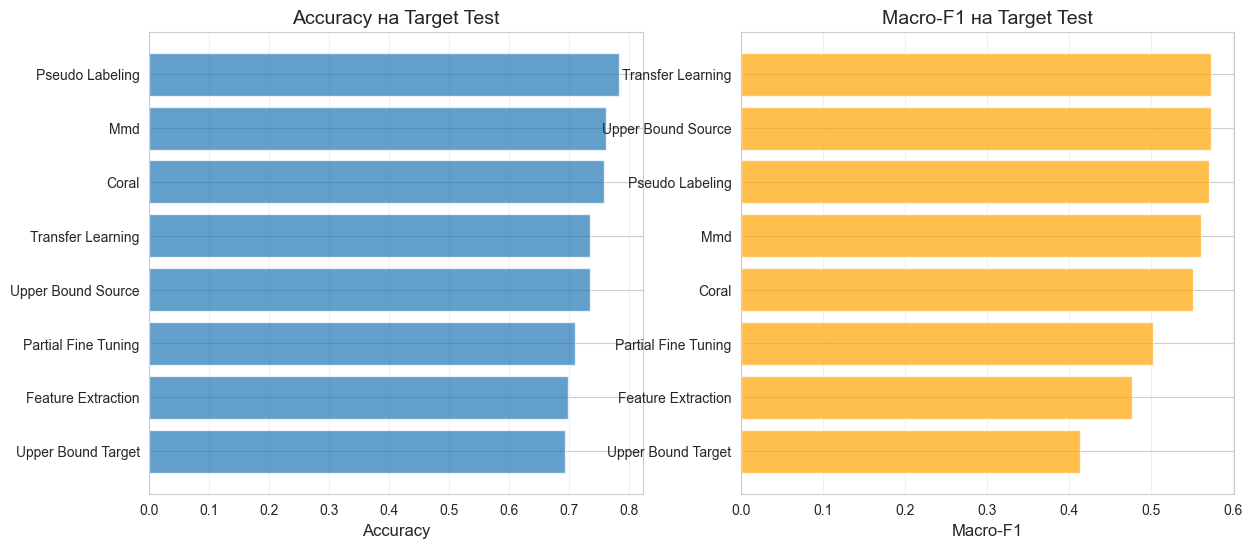

In [15]:
# Создание итоговой таблицы
comparison_data = []
for method_name, metrics in results.items():
    comparison_data.append({
        'Method': method_name.replace('_', ' ').title(),
        'Accuracy': metrics['test_acc'],
        'Macro-F1': metrics['test_f1']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Macro-F1', ascending=False)

print("=" * 80)
print("ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ DOMAIN ADAPTATION")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
ax = axes[0]
comparison_df_sorted = comparison_df.sort_values('Accuracy', ascending=True)
ax.barh(comparison_df_sorted['Method'], comparison_df_sorted['Accuracy'], alpha=0.7)
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_title('Accuracy на Target Test', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# Macro-F1
ax = axes[1]
comparison_df_sorted = comparison_df.sort_values('Macro-F1', ascending=True)
ax.barh(comparison_df_sorted['Method'], comparison_df_sorted['Macro-F1'], alpha=0.7, color='orange')
ax.set_xlabel('Macro-F1', fontsize=12)
ax.set_title('Macro-F1 на Target Test', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')


# Сохранение результатов
save_dir = Path("./checkpoints/domain_adaptation")
save_dir.mkdir(parents=True, exist_ok=True)

comparison_df.to_csv(save_dir / "comparison_results.csv", index=False)

with open(save_dir / "all_results.pkl", "wb") as f:
    pickle.dump(results, f)

print(f"\nРезультаты сохранены в {save_dir}")


## 13. Абляции: влияние параметров

Исследуем влияние размера размеченной части T, силы CORAL/MMD и порога псевдоразметки.


АБЛЯЦИЯ: Размер размеченной части Target домена

Размер labeled части: 1.0%


Epoch 5/20: Train Loss=3.0581, Train Acc=30.21%, Val Acc=0.40%, Val F1=0.1675


Epoch 10/20: Train Loss=2.2267, Train Acc=50.17%, Val Acc=0.57%, Val F1=0.2824


Epoch 15/20: Train Loss=1.9011, Train Acc=53.68%, Val Acc=0.62%, Val F1=0.3334


Epoch 20/20: Train Loss=1.7145, Train Acc=57.57%, Val Acc=0.65%, Val F1=0.3644
  Accuracy: 0.6484, F1: 0.3665

Размер labeled части: 2.0%


Epoch 5/20: Train Loss=2.3052, Train Acc=49.42%, Val Acc=0.58%, Val F1=0.2712


Epoch 10/20: Train Loss=1.7030, Train Acc=57.71%, Val Acc=0.66%, Val F1=0.3774


Epoch 15/20: Train Loss=1.4777, Train Acc=60.13%, Val Acc=0.68%, Val F1=0.4206


Epoch 20/20: Train Loss=1.4105, Train Acc=61.83%, Val Acc=0.69%, Val F1=0.4505
  Accuracy: 0.6902, F1: 0.4522

Размер labeled части: 3.0%


Epoch 5/20: Train Loss=2.0806, Train Acc=53.74%, Val Acc=0.61%, Val F1=0.3172


Epoch 10/20: Train Loss=1.6823, Train Acc=58.13%, Val Acc=0.66%, Val F1=0.3949


Epoch 15/20: Train Loss=1.5767, Train Acc=60.08%, Val Acc=0.66%, Val F1=0.4121


Epoch 20/20: Train Loss=1.5970, Train Acc=60.76%, Val Acc=0.69%, Val F1=0.4436
  Accuracy: 0.6867, F1: 0.4527

Размер labeled части: 5.0%


Epoch 5/20: Train Loss=1.6128, Train Acc=59.27%, Val Acc=0.67%, Val F1=0.4019


Epoch 10/20: Train Loss=1.3454, Train Acc=62.45%, Val Acc=0.70%, Val F1=0.4654


Epoch 15/20: Train Loss=1.2650, Train Acc=63.37%, Val Acc=0.71%, Val F1=0.4882


Epoch 20/20: Train Loss=1.2239, Train Acc=63.84%, Val Acc=0.72%, Val F1=0.5033
  Accuracy: 0.7157, F1: 0.5019

 labeled_ratio  n_labeled  accuracy       f1
          0.01       2390  0.648449 0.366533
          0.02       4781  0.690179 0.452170
          0.03       7172  0.686677 0.452660
          0.05      11954  0.715686 0.501930


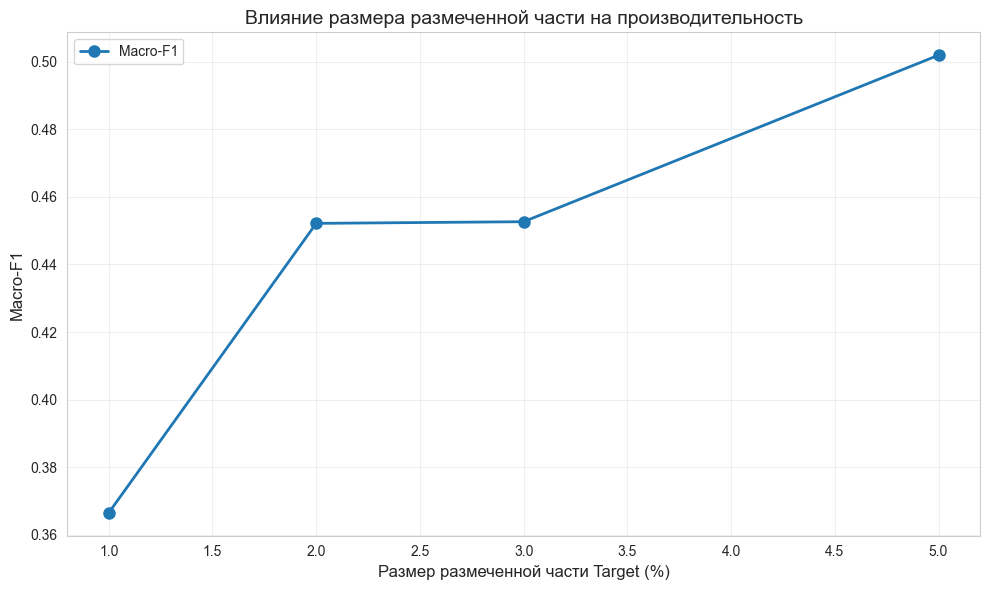

In [16]:
# Абляция: размер размеченной части T
print("="*60)
print("АБЛЯЦИЯ: Размер размеченной части Target домена")
print("="*60)

labeled_ratios = [0.01, 0.02, 0.03, 0.05]
ablation_labeled = []

for ratio in labeled_ratios:
    print(f"\nРазмер labeled части: {ratio*100:.1f}%")
    
    # Разделяем target данные
    X_tl, X_tu, y_tl, y_tu = train_test_split(
        X_target, y_target,
        test_size=1 - ratio,
        stratify=y_target,
        random_state=42
    )
    
    # Создаем DataLoader
    tl_dataset = TensorDataset(torch.FloatTensor(X_tl), torch.LongTensor(y_tl))
    tl_loader = DataLoader(tl_dataset, batch_size=512, shuffle=True, num_workers=4)
    
    # Feature Extraction
    model_ablation = DomainAdaptationModel(input_dim, n_classes, embedding_dim=embedding_dim).to(device)
    model_ablation.encoder.load_state_dict(model_source.encoder.state_dict())
    for param in model_ablation.encoder.parameters():
        param.requires_grad = False
    
    train_model(model_ablation, tl_loader, target_val_loader, n_epochs=20, lr=0.001, freeze_encoder=True)
    acc, f1, _, _ = evaluate(model_ablation, target_test_loader, device)
    
    ablation_labeled.append({
        'labeled_ratio': ratio,
        'n_labeled': len(X_tl),
        'accuracy': acc,
        'f1': f1
    })
    
    print(f"  Accuracy: {acc:.4f}, F1: {f1:.4f}")

ablation_labeled_df = pd.DataFrame(ablation_labeled)
print("\n" + ablation_labeled_df.to_string(index=False))

# Визуализация
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(ablation_labeled_df['labeled_ratio'] * 100, ablation_labeled_df['f1'], 
        marker='o', linewidth=2, markersize=8, label='Macro-F1')
ax.set_xlabel('Размер размеченной части Target (%)', fontsize=12)
ax.set_ylabel('Macro-F1', fontsize=12)
ax.set_title('Влияние размера размеченной части на производительность', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()



АБЛЯЦИЯ: Сила CORAL/MMD штрафа

Lambda: 0.0


Epoch 5/20: Train Loss=1.2693, Train Acc=66.24%, Val Acc=0.71%, Val F1=0.4158


Epoch 10/20: Train Loss=1.1472, Train Acc=72.57%, Val Acc=0.75%, Val F1=0.5097


Epoch 15/20: Train Loss=0.9287, Train Acc=74.89%, Val Acc=0.74%, Val F1=0.5241


Epoch 20/20: Train Loss=0.7362, Train Acc=75.74%, Val Acc=0.76%, Val F1=0.5370


Epoch 5/20: Train Loss=1.2965, Train Acc=67.33%, Val Acc=0.70%, Val F1=0.4125


Epoch 10/20: Train Loss=0.9369, Train Acc=73.72%, Val Acc=0.74%, Val F1=0.4992


Epoch 15/20: Train Loss=0.8506, Train Acc=74.21%, Val Acc=0.75%, Val F1=0.5383


Early stopping at epoch 19
  CORAL - Accuracy: 0.7635, F1: 0.5450
  MMD - Accuracy: 0.7504, F1: 0.5493

Lambda: 0.01


Epoch 5/20: Train Loss=1.3033, Train Acc=66.61%, Val Acc=0.70%, Val F1=0.4165


Epoch 10/20: Train Loss=1.0304, Train Acc=73.69%, Val Acc=0.74%, Val F1=0.5049


Epoch 15/20: Train Loss=0.7792, Train Acc=75.38%, Val Acc=0.74%, Val F1=0.5219


Epoch 20/20: Train Loss=0.7702, Train Acc=75.70%, Val Acc=0.75%, Val F1=0.5387


Epoch 5/20: Train Loss=1.2988, Train Acc=65.95%, Val Acc=0.69%, Val F1=0.3936


Epoch 10/20: Train Loss=0.8530, Train Acc=72.62%, Val Acc=0.74%, Val F1=0.5065


Epoch 15/20: Train Loss=0.9757, Train Acc=74.47%, Val Acc=0.74%, Val F1=0.5220


Epoch 20/20: Train Loss=0.7144, Train Acc=75.93%, Val Acc=0.75%, Val F1=0.5322
  CORAL - Accuracy: 0.7549, F1: 0.5399
  MMD - Accuracy: 0.7493, F1: 0.5344

Lambda: 0.05


Epoch 5/20: Train Loss=1.2688, Train Acc=67.02%, Val Acc=0.69%, Val F1=0.4064


Epoch 10/20: Train Loss=1.0216, Train Acc=73.55%, Val Acc=0.75%, Val F1=0.5142


Epoch 15/20: Train Loss=0.8820, Train Acc=74.89%, Val Acc=0.76%, Val F1=0.5300


Epoch 20/20: Train Loss=0.7653, Train Acc=76.14%, Val Acc=0.76%, Val F1=0.5352


Epoch 5/20: Train Loss=1.3090, Train Acc=66.97%, Val Acc=0.71%, Val F1=0.4255


Epoch 10/20: Train Loss=0.9014, Train Acc=73.38%, Val Acc=0.75%, Val F1=0.5139


Epoch 15/20: Train Loss=0.7831, Train Acc=75.56%, Val Acc=0.76%, Val F1=0.5365


Epoch 20/20: Train Loss=0.8953, Train Acc=77.04%, Val Acc=0.76%, Val F1=0.5512
  CORAL - Accuracy: 0.7546, F1: 0.5366
  MMD - Accuracy: 0.7655, F1: 0.5570

Lambda: 0.1


Epoch 5/20: Train Loss=1.2598, Train Acc=66.76%, Val Acc=0.70%, Val F1=0.4171


Epoch 10/20: Train Loss=0.8833, Train Acc=74.30%, Val Acc=0.75%, Val F1=0.5220


Epoch 15/20: Train Loss=0.8560, Train Acc=75.73%, Val Acc=0.76%, Val F1=0.5326


Epoch 20/20: Train Loss=0.9510, Train Acc=76.51%, Val Acc=0.76%, Val F1=0.5417


Epoch 5/20: Train Loss=1.3634, Train Acc=65.85%, Val Acc=0.70%, Val F1=0.4069


Epoch 10/20: Train Loss=1.2372, Train Acc=72.32%, Val Acc=0.73%, Val F1=0.4885


Epoch 15/20: Train Loss=1.0220, Train Acc=74.02%, Val Acc=0.74%, Val F1=0.5180


Epoch 20/20: Train Loss=1.0072, Train Acc=75.99%, Val Acc=0.75%, Val F1=0.5326
  CORAL - Accuracy: 0.7640, F1: 0.5497
  MMD - Accuracy: 0.7465, F1: 0.5416

Lambda: 0.2


Epoch 5/20: Train Loss=1.2379, Train Acc=65.38%, Val Acc=0.70%, Val F1=0.3983


Epoch 10/20: Train Loss=0.9418, Train Acc=73.13%, Val Acc=0.73%, Val F1=0.4996


Epoch 15/20: Train Loss=0.8419, Train Acc=74.60%, Val Acc=0.74%, Val F1=0.5140


Epoch 20/20: Train Loss=0.9087, Train Acc=76.52%, Val Acc=0.75%, Val F1=0.5326


Epoch 5/20: Train Loss=1.6866, Train Acc=64.77%, Val Acc=0.69%, Val F1=0.3939


Epoch 10/20: Train Loss=1.2810, Train Acc=70.90%, Val Acc=0.74%, Val F1=0.4858


Epoch 15/20: Train Loss=1.1992, Train Acc=72.39%, Val Acc=0.74%, Val F1=0.5131


Epoch 20/20: Train Loss=1.0987, Train Acc=73.76%, Val Acc=0.75%, Val F1=0.5365
  CORAL - Accuracy: 0.7551, F1: 0.5445
  MMD - Accuracy: 0.7488, F1: 0.5365

Lambda: 0.5


Epoch 5/20: Train Loss=1.1948, Train Acc=67.02%, Val Acc=0.70%, Val F1=0.4183


Epoch 10/20: Train Loss=0.8554, Train Acc=73.79%, Val Acc=0.72%, Val F1=0.5046


Epoch 15/20: Train Loss=0.8334, Train Acc=75.98%, Val Acc=0.74%, Val F1=0.5341


Epoch 20/20: Train Loss=0.8697, Train Acc=77.16%, Val Acc=0.75%, Val F1=0.5444


Epoch 5/20: Train Loss=1.9798, Train Acc=59.29%, Val Acc=0.67%, Val F1=0.3824


Epoch 10/20: Train Loss=1.6561, Train Acc=66.56%, Val Acc=0.69%, Val F1=0.4519


Epoch 15/20: Train Loss=1.4225, Train Acc=69.21%, Val Acc=0.71%, Val F1=0.4791


Epoch 20/20: Train Loss=1.4643, Train Acc=70.18%, Val Acc=0.72%, Val F1=0.5023
  CORAL - Accuracy: 0.7506, F1: 0.5520
  MMD - Accuracy: 0.7168, F1: 0.5063


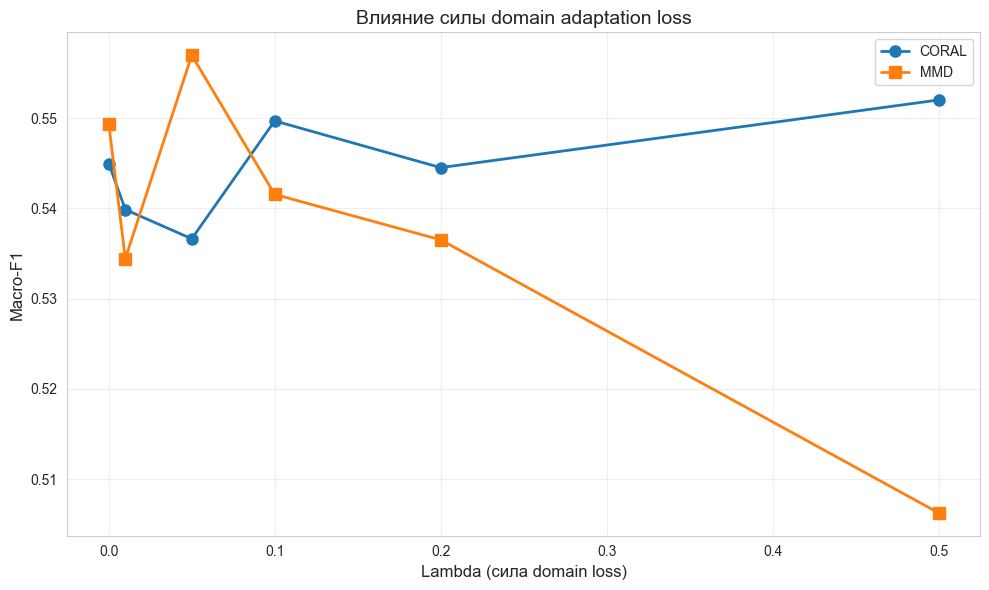

In [17]:
# Абляция: сила CORAL/MMD
print("\n" + "="*60)
print("АБЛЯЦИЯ: Сила CORAL/MMD штрафа")
print("="*60)

lambda_values = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
ablation_coral = []
ablation_mmd = []

for lambda_val in lambda_values:
    print(f"\nLambda: {lambda_val}")
    
    # CORAL
    model_coral_ablation = DomainAdaptationModel(input_dim, n_classes, embedding_dim=embedding_dim).to(device)
    model_coral_ablation.encoder.load_state_dict(model_source.encoder.state_dict())
    
    train_model(
        model_coral_ablation, target_labeled_loader, target_val_loader,
        n_epochs=20, lr=0.001,
        domain_loss_fn=coral_loss, lambda_domain=lambda_val, source_dataloader=source_loader
    )
    acc_coral, f1_coral, _, _ = evaluate(model_coral_ablation, target_test_loader, device)
    ablation_coral.append({'lambda': lambda_val, 'accuracy': acc_coral, 'f1': f1_coral})
    
    # MMD
    model_mmd_ablation = DomainAdaptationModel(input_dim, n_classes, embedding_dim=embedding_dim).to(device)
    model_mmd_ablation.encoder.load_state_dict(model_source.encoder.state_dict())
    
    train_model(
        model_mmd_ablation, target_labeled_loader, target_val_loader,
        n_epochs=20, lr=0.001,
        domain_loss_fn=lambda s, t: mmd_loss(s, t, kernel='linear'),
        lambda_domain=lambda_val, source_dataloader=source_loader
    )
    acc_mmd, f1_mmd, _, _ = evaluate(model_mmd_ablation, target_test_loader, device)
    ablation_mmd.append({'lambda': lambda_val, 'accuracy': acc_mmd, 'f1': f1_mmd})
    
    print(f"  CORAL - Accuracy: {acc_coral:.4f}, F1: {f1_coral:.4f}")
    print(f"  MMD - Accuracy: {acc_mmd:.4f}, F1: {f1_mmd:.4f}")

ablation_coral_df = pd.DataFrame(ablation_coral)
ablation_mmd_df = pd.DataFrame(ablation_mmd)


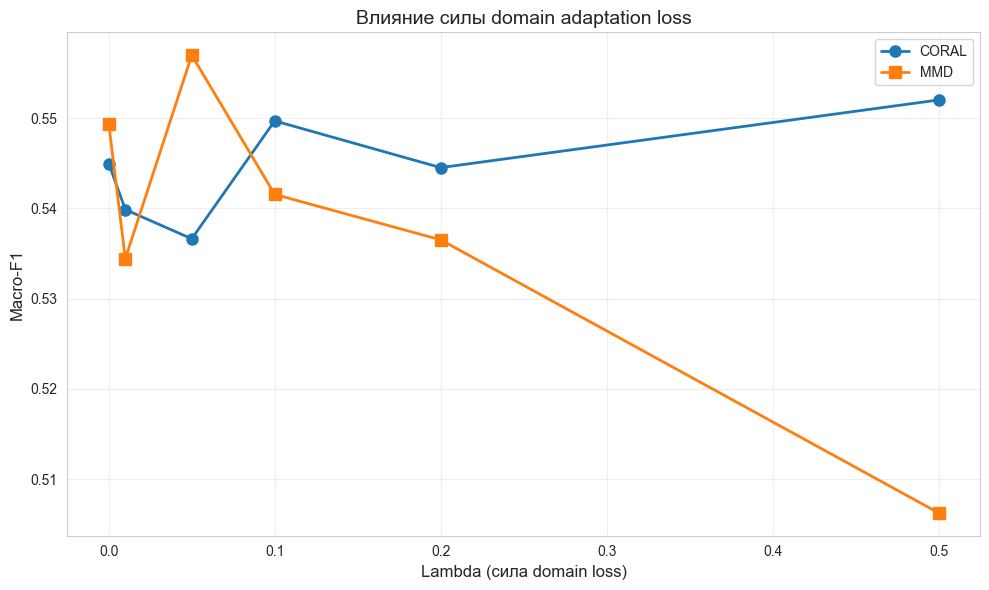

In [18]:
# Визуализация
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(ablation_coral_df['lambda'], ablation_coral_df['f1'], 
        marker='o', linewidth=2, label='CORAL', markersize=8)
ax.plot(ablation_mmd_df['lambda'], ablation_mmd_df['f1'], 
        marker='s', linewidth=2, label='MMD', markersize=8)
ax.set_xlabel('Lambda (сила domain loss)', fontsize=12)
ax.set_ylabel('Macro-F1', fontsize=12)
ax.set_title('Влияние силы domain adaptation loss', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()